In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rameshkuntigorla","key":"8ff4e3306a7a97ba5f17c6cccaf37807"}'}

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d medical_images

Streaming output truncated to the last 5000 lines.
  inflating: medical_images/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: medical_images/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: medical_images/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: medical_images/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: medical_images/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: medical_images/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: medical_images/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: medical_images/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: medical_images/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: medical_images/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: medical_images/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: medical_images/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: medical_images/chest_xray/train/NORMAL/IM-0444-

In [ ]:
# import cv2
# import numpy as np
# import os
# import matplotlib.pyplot as plt

# train_dir = "/content/medical_images/chest_xray/train/"

# for img in os.listdir( train_dir + "/NORMAL"):
#     img_array = cv2.imread(train_dir + "/NORMAL/" + img)

#     img_array = cv2.resize(img_array, (128,128))
#     lr_img_array = cv2.resize(img_array,(32,32))
#     cv2.imwrite(train_dir+ "/hr_images/" + img, img_array)
#     cv2.imwrite(train_dir+ "/lr_images/"+ img, lr_img_array)

# for img in os.listdir( train_dir + "/PNEUMONIA"):
#     img_array = cv2.imread(train_dir + "/PNEUMONIA/" + img)

#     img_array = cv2.resize(img_array, (128,128))
#     lr_img_array = cv2.resize(img_array,(32,32))
#     cv2.imwrite(train_dir+ "/hr_images/" + img, img_array)
#     cv2.imwrite(train_dir+ "/lr_images/"+ img, lr_img_array)

In [ ]:
import cv2
import numpy as np
import os

train_dir = "/content/medical_images/chest_xray/train/"
hr_dir = train_dir + "hr_images/"
lr_dir = train_dir + "lr_images/"

# Create directories if they don't exist
os.makedirs(hr_dir, exist_ok=True)
os.makedirs(lr_dir, exist_ok=True)

# Classes to process
classes = ["NORMAL", "PNEUMONIA"]

for cls in classes:
    cls_path = os.path.join(train_dir, cls)

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue  # Skip unreadable files

        # Resize to HR and LR
        hr_img = cv2.resize(img, (128, 128))
        lr_img = cv2.resize(hr_img, (32, 32))

        # Save using unique filenames
        new_name = f"{cls}_{img_name}"
        cv2.imwrite(os.path.join(hr_dir, new_name), hr_img)
        cv2.imwrite(os.path.join(lr_dir, new_name), lr_img)

print("✅ Images processed and saved to hr_images and lr_images folders.")


✅ Images processed and saved to hr_images and lr_images folders.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

print('This is the implementation of Super resolution Generative Adversial network')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

This is the implementation of Super resolution Generative Adversial network


In [ ]:
! pip install opencv-python tensorflow

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, PReLU, BatchNormalization, Flatten
from tensorflow.keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [ ]:
def res_block(ip):
    res_model = Conv2D(64,(3,3), padding= "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64,(3,3), padding= "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip, res_model])

In [ ]:
def upscale_block(ip):
    up_model = Conv2D(256, (3,3), padding= "same")(ip)
    up_model = UpSampling2D(size=2)(up_model)
    up_model = PReLU(shared_axes = [1,2])(up_model)

    return up_model

In [ ]:
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes = [1,2])(layers)

    temp = layers
    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum = 0.5)(layers)
    layers = add([layers, temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3,(9,9), padding="same")(layers)
    return Model(inputs=gen_ip, outputs=op)


In [ ]:
def discriminator_block(ip, filters, strides=1, bn=True):
    disc_model = Conv2D(filters, (3,3), strides = strides, padding= "same")(ip)

    if bn:
        disc_model = BatchNormalization(momentum = 0.8)(disc_model)

    disc_model = LeakyReLU(alpha=0.2)(disc_model)
    return disc_model

In [ ]:
def create_disc(disc_ip):
    df = 64
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides = 2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides = 2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides = 2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df * 16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [ ]:
from tensorflow.keras.applications import VGG19

def build_vgg(hr_shape):
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)
    return Model(inputs = vgg.inputs, outputs = vgg.layers[10].output)

In [ ]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [ ]:
n = 5000
lr_list = os.listdir('/content/medical_images/chest_xray/train/lr_images/')

lr_images = []
for i in range(n):
    img_lr = cv2.imread(f'/content/medical_images/chest_xray/train/lr_images/{lr_list[i]}')
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)

hr_list = os.listdir('/content/medical_images/chest_xray/train/hr_images/')

hr_images = []
for i in range(n):
    img_hr = cv2.imread(f'/content/medical_images/chest_xray/train/hr_images/{hr_list[i]}')
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)
print('process completed')

process completed


In [ ]:
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

lr_images.shape,hr_images.shape

((5000, 32, 32, 3), (5000, 128, 128, 3))

In [ ]:
lr_images = lr_images / 255
hr_images = hr_images / 255

In [ ]:
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size = 0.33, random_state=42)
lr_train.shape, hr_train.shape

((3350, 32, 32, 3), (3350, 128, 128, 3))

In [ ]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
lr_shape , hr_shape

((32, 32, 3), (128, 128, 3))

In [ ]:
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │     15,616 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_19 (PReLU)  │ (None, 32, 32,    │         64 │ conv2d_45[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 32, 32,    │     36,928 │ p_re_lu_19[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_20 (PReLU)  │ (None, 32, 32,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 32, 32,    │     36,928 │ p_re_lu_20[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 32, 32,    │          0 │ p_re_lu_19[0][0], │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 32, 32,    │     36,928 │ add_17[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_21 (PReLU)  │ (None, 32, 32,    │         64 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 32, 32,    │     36,928 │ p_re_lu_21[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 32, 32,    │          0 │ add_17[0][0],     │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 32, 32,    │     36,928 │ add_18[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_50[0][0] 

 Total params: 2,044,291 (7.80 MB)

 Trainable params: 2,040,067 (7.78 MB)

 Non-trainable params: 4,224 (16.50 KB)

In [ ]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss= "binary_crossentropy", optimizer="adam",metrics=['accuracy'])
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,80

 Total params: 38,249,281 (145.91 MB)

 Trainable params: 38,245,569 (145.90 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [ ]:
vgg = build_vgg((128, 128, 3))
print(vgg.summary())
vgg.trainable = False

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325,568 (8.87 MB)

 Trainable params: 2,325,568 (8.87 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3,1],optimizer="adam")
gan_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 128, 128,  │  2,044,291 │ input_layer_3[0]… │
│ (Functional)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 1)         │ 38,249,281 │ functional_4[0][… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ (None, 32, 32,    │  2,325,568 │ functional_4[0][… │
│ (Functional)        │ 256)              │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,619,140 (162.58 MB)

 Trainable params: 2,040,067 (7.78 MB)

 Non-trainable params: 40,579,073 (154.80 MB)

In [ ]:
batch_size = 32
train_lr_batches = []
train_hr_batches = []

for it in range(int(hr_train.shape[0]/ batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

print('process complete')

process complete


In [ ]:
import tensorflow as tf

# Check GPU availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Show where each op is placed
tf.debugging.set_log_device_placement(True)

Num GPUs Available: 1


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt


# with tf.device('/GPU:0'):
#     epochs = 100
# Enumerate training over epochs
#     for e in range(epochs):

#         fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
#         real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

#         Create empty lists to populate gen and disc losses.
#         g_losses = []
#         d_losses = []

#         Enumerate training over batches.
#         for b in tqdm(range(len(train_hr_batches))):
#             lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
#             hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

#             fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

#             First, train the discriminator on fake and real HR images.
#             discriminator.trainable = True
#             d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
#             d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

#             Now, train the generator by fixing discriminator as non-trainable
#             discriminator.trainable = False

#             Average the discriminator loss, just for reporting purposes.
#             d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

#             Extract VGG features, to be used towards calculating loss
#             image_features = vgg.predict(hr_imgs, verbose=0)

#             Train the generator via GAN.
#             Remember that we have 2 losses, adversarial loss and content (VGG) loss
#             loss = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
#             g_loss = loss[0]
#             Save losses to a list so we can average and report.
#             d_losses.append(d_loss)
#             g_losses.append(g_loss)

#         Convert the list of losses to an array to make it easy to average
#         g_losses = np.array(g_losses)
#         d_losses = np.array(d_losses)

#         Calculate the average losses for generator and discriminator
#         g_loss = np.sum(g_losses, axis=0) / len(g_losses)
#         d_loss = np.sum(d_losses, axis=0) / len(d_losses)

#         Report the progress during training.
#         print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

#             Save the generator after every n epochs (Usually 10 epochs)
#         generator.save("gen_e_"+ str(e+1) +".h5")

# Create lists to store PSNR and SSIM values for each epoch
epoch_psnr = []
epoch_ssim = []

with tf.device('/GPU:0'):
    epochs = 120
    for e in range(epochs):

        fake_label = np.zeros((batch_size, 1))
        real_label = np.ones((batch_size, 1))

        g_losses = []
        d_losses = []
        batch_psnr = []
        batch_ssim = []

        for b in tqdm(range(len(train_hr_batches))):
            lr_imgs = train_lr_batches[b]
            hr_imgs = train_hr_batches[b]

            fake_imgs = generator.predict_on_batch(lr_imgs)

            # Discriminator training
            discriminator.trainable = True
            d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
            d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

            discriminator.trainable = False
            d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

            image_features = vgg.predict(hr_imgs, verbose=0)
            loss = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
            g_loss = loss[0]

            d_losses.append(d_loss)
            g_losses.append(g_loss)

            for i in range(fake_imgs.shape[0]):
                img_fake = np.clip(fake_imgs[i], 0, 1)
                img_real = np.clip(hr_imgs[i], 0, 1)
                psnr_val = psnr(img_real, img_fake, data_range=1.0)
                ssim_val = ssim(img_real, img_fake, data_range=1.0, channel_axis=-1)
                batch_psnr.append(psnr_val)
                batch_ssim.append(ssim_val)


        g_loss = np.mean(g_losses)
        d_loss = np.mean(d_losses)
        avg_psnr = np.mean(batch_psnr)
        avg_ssim = np.mean(batch_ssim)

        # Store epoch-wise PSNR and SSIM
        epoch_psnr.append(avg_psnr)
        epoch_ssim.append(avg_ssim)

        print(f"Epoch: {e+1}, g_loss: {g_loss:.4f}, d_loss: {d_loss:.4f}, PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}")

        generator.save(f"gen_e_{e+1}.h5")





  0%|          | 0/104 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3794']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)
100%|██████████| 104/104 [03:22<00:00,  1.95s/it]


Epoch: 1, g_loss: 119.8187, d_loss: 4.0244, PSNR: 11.1414, SSIM: 0.3271


100%|██████████| 104/104 [02:02<00:00,  1.17s/it]


Epoch: 2, g_loss: 53.2930, d_loss: 1.3487, PSNR: 20.3815, SSIM: 0.6180


100%|██████████| 104/104 [02:01<00:00,  1.17s/it]


Epoch: 3, g_loss: 38.0109, d_loss: 1.0203, PSNR: 23.2328, SSIM: 0.7108


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 4, g_loss: 30.4012, d_loss: 0.8862, PSNR: 23.9866, SSIM: 0.7278


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 5, g_loss: 25.8962, d_loss: 0.8126, PSNR: 24.4746, SSIM: 0.7369


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 6, g_loss: 22.9002, d_loss: 0.7572, PSNR: 24.8698, SSIM: 0.7435


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 7, g_loss: 20.7480, d_loss: 0.7192, PSNR: 25.0147, SSIM: 0.7473


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 8, g_loss: 19.1254, d_loss: 0.6906, PSNR: 25.2647, SSIM: 0.7522


100%|██████████| 104/104 [02:01<00:00,  1.17s/it]


Epoch: 9, g_loss: 17.8485, d_loss: 0.6691, PSNR: 25.4373, SSIM: 0.7549


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 10, g_loss: 16.8170, d_loss: 0.6526, PSNR: 25.3954, SSIM: 0.7571


100%|██████████| 104/104 [01:59<00:00,  1.15s/it]


Epoch: 11, g_loss: 15.9633, d_loss: 0.6390, PSNR: 25.5443, SSIM: 0.7597


100%|██████████| 104/104 [01:59<00:00,  1.15s/it]


Epoch: 12, g_loss: 15.2408, d_loss: 0.6270, PSNR: 25.5821, SSIM: 0.7629


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 13, g_loss: 14.6216, d_loss: 0.6169, PSNR: 25.6423, SSIM: 0.7649


100%|██████████| 104/104 [02:00<00:00,  1.15s/it]


Epoch: 14, g_loss: 14.0819, d_loss: 0.6122, PSNR: 25.6757, SSIM: 0.7663


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 15, g_loss: 13.6088, d_loss: 0.6241, PSNR: 25.7843, SSIM: 0.7672


100%|██████████| 104/104 [02:01<00:00,  1.17s/it]


Epoch: 16, g_loss: 13.1893, d_loss: 0.6189, PSNR: 25.7872, SSIM: 0.7679


100%|██████████| 104/104 [02:01<00:00,  1.17s/it]


Epoch: 17, g_loss: 12.8118, d_loss: 0.6131, PSNR: 25.9041, SSIM: 0.7689


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 18, g_loss: 12.4700, d_loss: 0.6067, PSNR: 25.9145, SSIM: 0.7692


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 19, g_loss: 12.1594, d_loss: 0.6009, PSNR: 25.9413, SSIM: 0.7693


100%|██████████| 104/104 [02:01<00:00,  1.17s/it]


Epoch: 20, g_loss: 11.8763, d_loss: 0.5959, PSNR: 25.9522, SSIM: 0.7693


100%|██████████| 104/104 [02:01<00:00,  1.17s/it]


Epoch: 21, g_loss: 11.6169, d_loss: 0.5914, PSNR: 25.8846, SSIM: 0.7696


100%|██████████| 104/104 [02:01<00:00,  1.17s/it]


Epoch: 22, g_loss: 11.3779, d_loss: 0.5872, PSNR: 25.9256, SSIM: 0.7697


100%|██████████| 104/104 [02:01<00:00,  1.17s/it]


Epoch: 23, g_loss: 11.1568, d_loss: 0.5839, PSNR: 25.8424, SSIM: 0.7700


100%|██████████| 104/104 [02:01<00:00,  1.16s/it]


Epoch: 24, g_loss: 10.9519, d_loss: 0.5806, PSNR: 25.8257, SSIM: 0.7707


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 25, g_loss: 10.7615, d_loss: 0.5773, PSNR: 25.8506, SSIM: 0.7710


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 26, g_loss: 10.5831, d_loss: 0.5743, PSNR: 25.8549, SSIM: 0.7716


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 27, g_loss: 10.4177, d_loss: 0.5715, PSNR: 25.7664, SSIM: 0.7711


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 28, g_loss: 10.2628, d_loss: 0.5689, PSNR: 25.8958, SSIM: 0.7715


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 29, g_loss: 10.1145, d_loss: 0.5664, PSNR: 25.9952, SSIM: 0.7723


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 30, g_loss: 9.9728, d_loss: 0.5642, PSNR: 25.9790, SSIM: 0.7725


100%|██████████| 104/104 [02:01<00:00,  1.16s/it]


Epoch: 31, g_loss: 9.8392, d_loss: 0.5621, PSNR: 25.9642, SSIM: 0.7727


100%|██████████| 104/104 [01:59<00:00,  1.15s/it]


Epoch: 32, g_loss: 9.7136, d_loss: 0.5601, PSNR: 25.9398, SSIM: 0.7721


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 33, g_loss: 9.5955, d_loss: 0.5583, PSNR: 25.9309, SSIM: 0.7726


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 34, g_loss: 9.4824, d_loss: 0.5565, PSNR: 25.9261, SSIM: 0.7730


100%|██████████| 104/104 [02:00<00:00,  1.16s/it]


Epoch: 35, g_loss: 9.3735, d_loss: 0.5549, PSNR: 25.8941, SSIM: 0.7727


100%|██████████| 104/104 [02:01<00:00,  1.17s/it]


Epoch: 36, g_loss: 9.2673, d_loss: 0.5533, PSNR: 25.8832, SSIM: 0.7729


100%|██████████| 104/104 [02:01<00:00,  1.17s/it]


Epoch: 37, g_loss: 9.1644, d_loss: 0.5519, PSNR: 25.8396, SSIM: 0.7723


100%|██████████| 104/104 [02:01<00:00,  1.17s/it]


Epoch: 38, g_loss: 9.0671, d_loss: 0.5505, PSNR: 25.8880, SSIM: 0.7723


100%|██████████| 104/104 [02:01<00:00,  1.17s/it]


Epoch: 39, g_loss: 8.9735, d_loss: 0.5492, PSNR: 25.6141, SSIM: 0.7710


100%|██████████| 104/104 [02:01<00:00,  1.17s/it]


Epoch: 40, g_loss: 20.9268, d_loss: 0.5580, PSNR: 12.5103, SSIM: 0.4535


 16%|█▋        | 17/104 [00:20<01:45,  1.21s/it]


KeyboardInterrupt: 

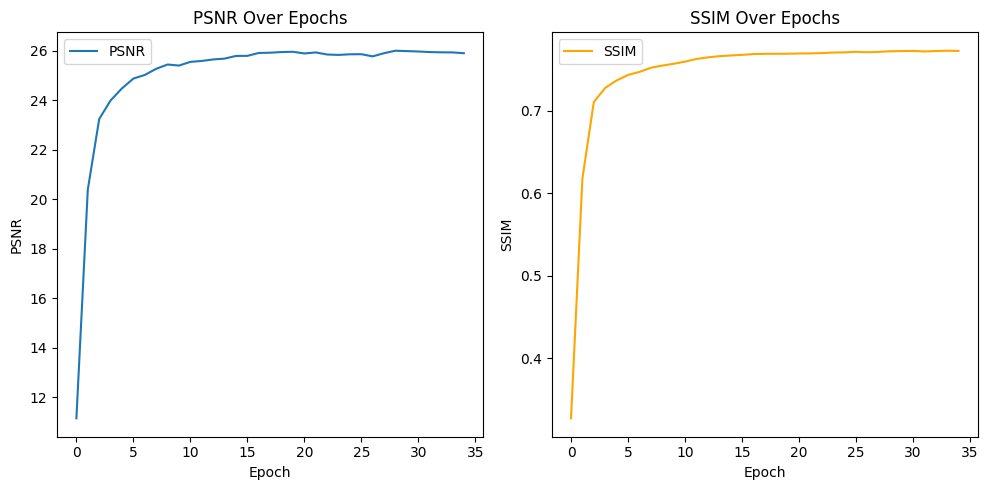

In [ ]:
# Plot PSNR and SSIM after training
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_psnr[:35], label='PSNR')
plt.title('PSNR Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_ssim[:35], label='SSIM', color='orange')
plt.title('SSIM Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


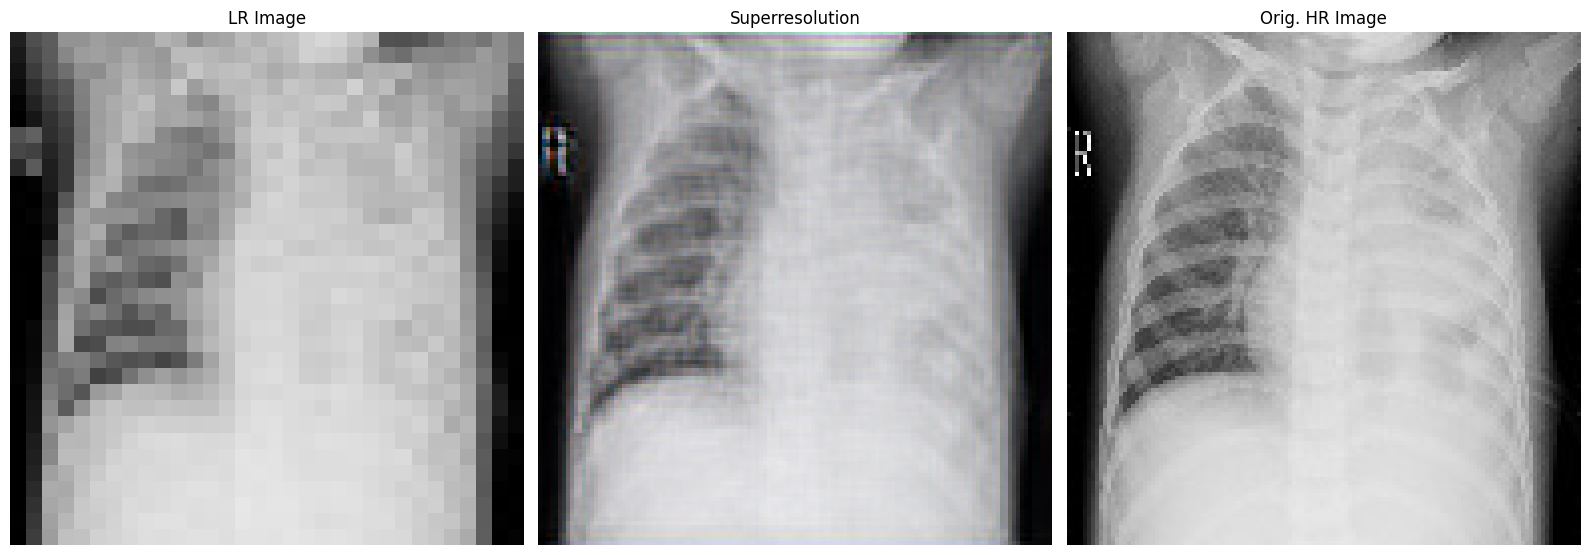

✅ Saved: lr_image.png, hr_image.png, sr_image.png in output_images/


In [ ]:
from keras.models import load_model
from numpy.random import randint
import matplotlib.pyplot as plt
import imageio
import os

# Load model
generator = load_model('gen_e_35.h5', compile=False)

# [lr_test, hr_test] must already be loaded/prepared as NumPy arrays
[X1, X2] = [lr_test, hr_test]

# Select random index
ix = randint(0, len(X1), 1)[0]
src_image, tar_image = X1[ix], X2[ix]

# Generate super-res image
gen_image = generator.predict(src_image[np.newaxis, ...])

# Plot all three images
plt.figure(figsize=(16, 8))

plt.subplot(131)
plt.title('LR Image')
plt.imshow(src_image)
plt.axis('off')

plt.subplot(132)
plt.title('Superresolution')
plt.imshow(gen_image[0])
plt.axis('off')

plt.subplot(133)
plt.title('Orig. HR Image')
plt.imshow(tar_image)
plt.axis('off')

plt.tight_layout()
plt.show()

# Save all images for download
os.makedirs("output_images", exist_ok=True)
imageio.imwrite("output_images/lr_image.png", (src_image * 255).astype("uint8"))
imageio.imwrite("output_images/hr_image.png", (tar_image * 255).astype("uint8"))
imageio.imwrite("output_images/sr_image.png", (gen_image[0] * 255).astype("uint8"))

print("✅ Saved: lr_image.png, hr_image.png, sr_image.png in output_images/")


104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step
Test Set Evaluation:
Average PSNR: 26.2301
Average SSIM: 0.7695


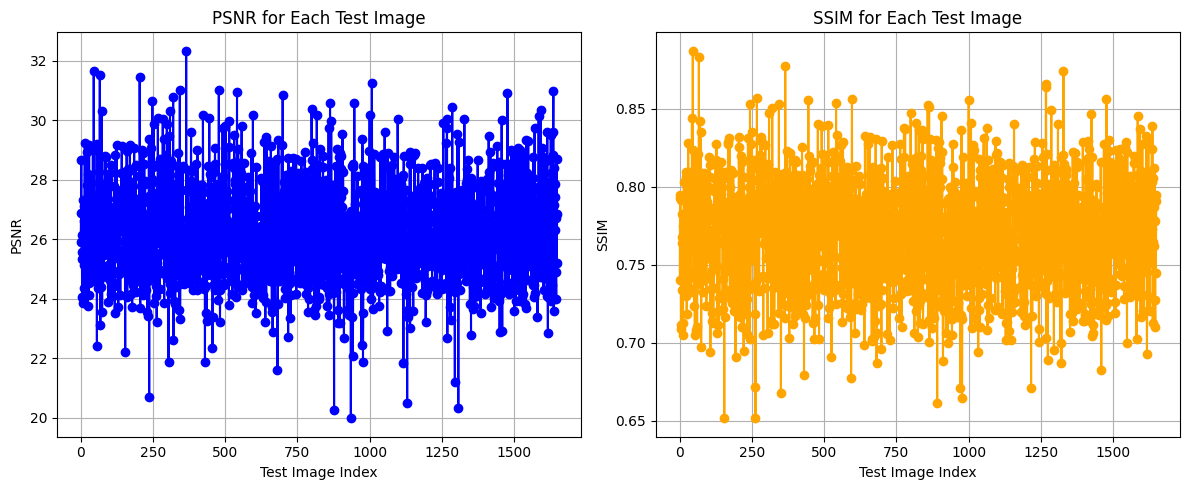

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Predict high-res images using the generator
generated_hr = generator.predict(lr_test, batch_size=16, verbose=1)

# Initialize lists to store PSNR and SSIM values
psnr_list = []
ssim_list = []

# Loop through each image in the test set
for i in range(len(hr_test)):
    real_img = np.clip(hr_test[i], 0, 1)
    fake_img = np.clip(generated_hr[i], 0, 1)

    psnr_val = psnr(real_img, fake_img, data_range=1.0)
    ssim_val = ssim(real_img, fake_img, data_range=1.0, channel_axis=-1)

    psnr_list.append(psnr_val)
    ssim_list.append(ssim_val)

# Calculate the average PSNR and SSIM
avg_psnr = np.mean(psnr_list)
avg_ssim = np.mean(ssim_list)

print(f"Test Set Evaluation:")
print(f"Average PSNR: {avg_psnr:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")


# Plot PSNR for all test images
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(psnr_list, marker='o', linestyle='-', color='blue')
plt.title('PSNR for Each Test Image')
plt.xlabel('Test Image Index')
plt.ylabel('PSNR')
plt.grid(True)

# Plot SSIM for all test images
plt.subplot(1, 2, 2)
plt.plot(ssim_list, marker='o', linestyle='-', color='orange')
plt.title('SSIM for Each Test Image')
plt.xlabel('Test Image Index')
plt.ylabel('SSIM')
plt.grid(True)

plt.tight_layout()
plt.show()


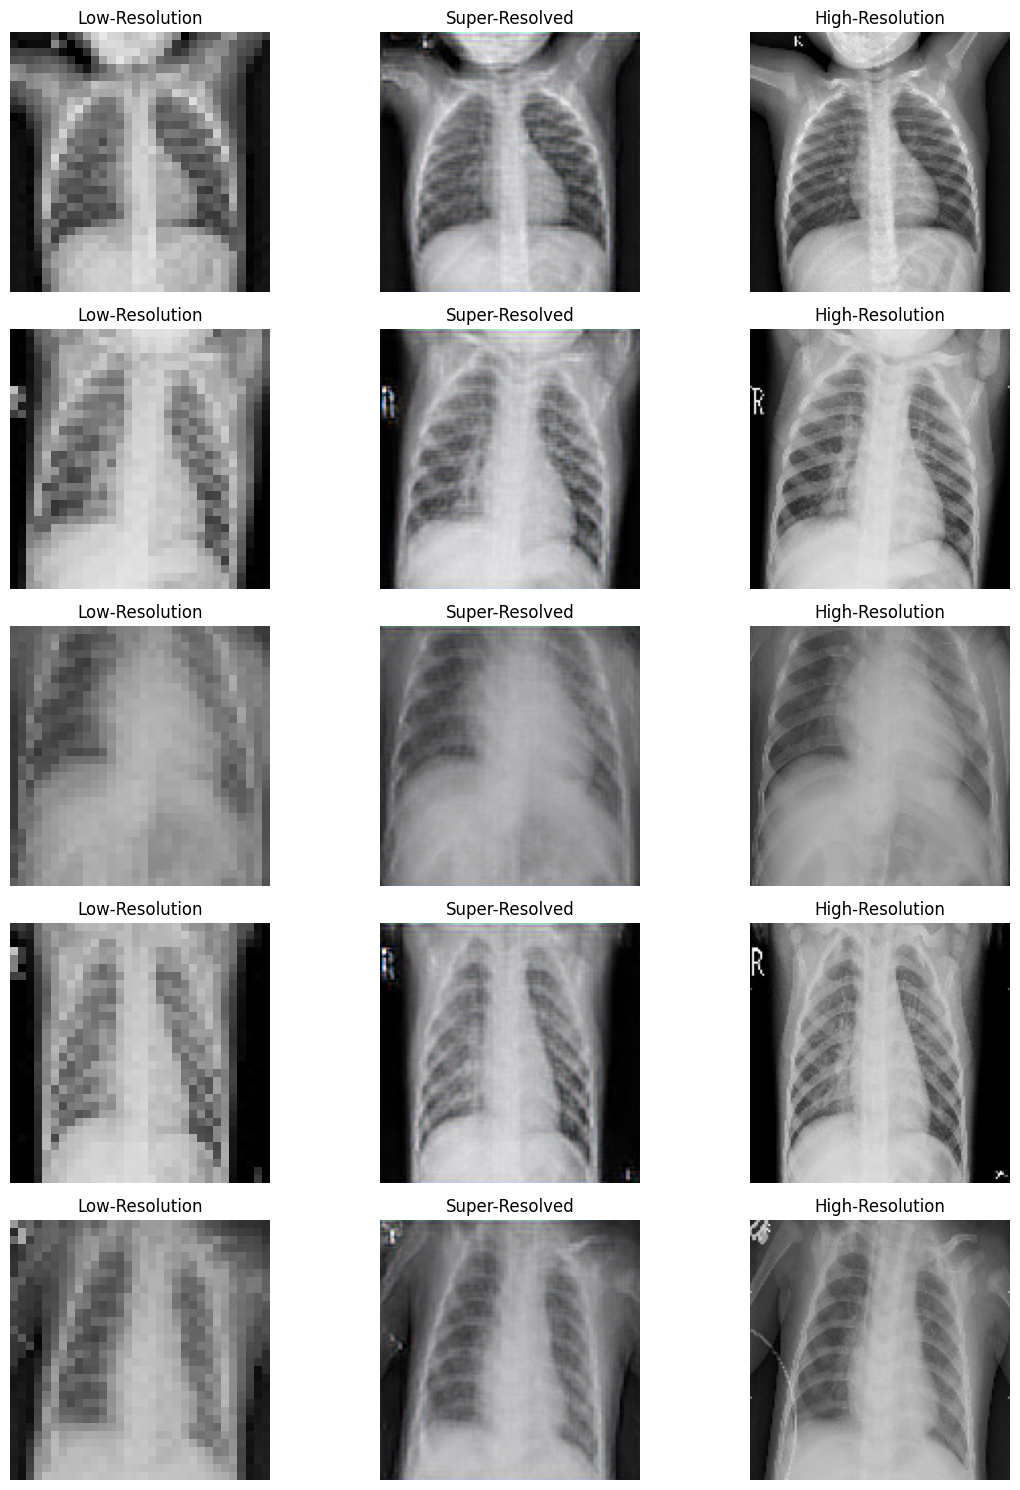

In [ ]:
import matplotlib.pyplot as plt

# Number of images to visualize
num_images = 5

plt.figure(figsize=(12, num_images * 3))

for i in range(num_images):
    idx = np.random.randint(0, len(lr_test))

    # Clip and fetch images
    lr_img = np.clip(lr_test[idx], 0, 1)
    sr_img = np.clip(generated_hr[idx], 0, 1)
    hr_img = np.clip(hr_test[idx], 0, 1)

    # LR image
    plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(lr_img)
    plt.title('Low-Resolution')
    plt.axis('off')

    # SR image
    plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(sr_img)
    plt.title('Super-Resolved')
    plt.axis('off')

    # HR image
    plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(hr_img)
    plt.title('High-Resolution')
    plt.axis('off')

plt.tight_layout()
plt.show()


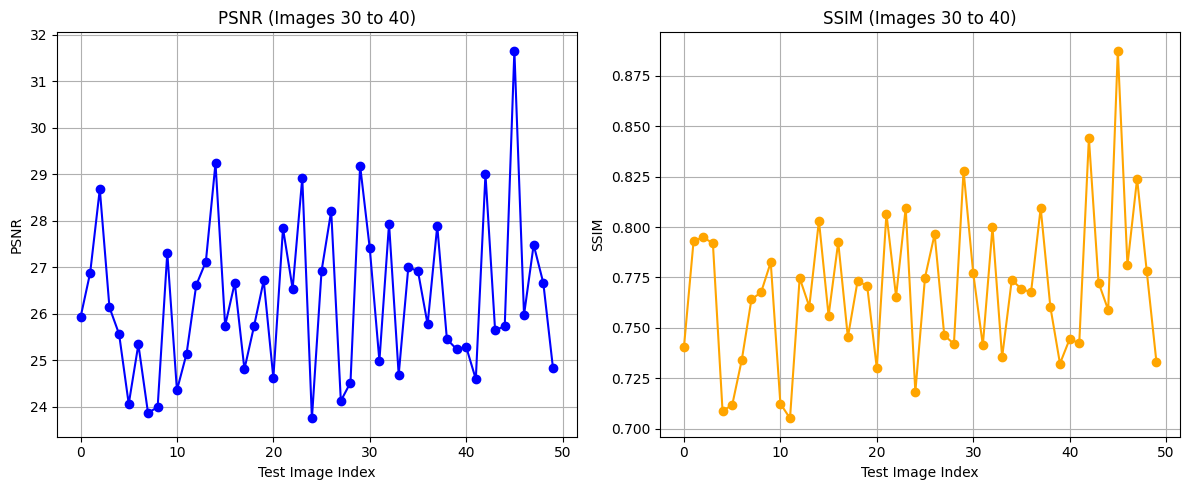

In [ ]:
indices = list(range(0, 50))

# Plot PSNR and SSIM for selected range
plt.figure(figsize=(12, 5))

# PSNR Plot
plt.subplot(1, 2, 1)
plt.plot(indices, [psnr_list[i] for i in indices], marker='o', color='blue')
plt.title('PSNR (Images 30 to 40)')
plt.xlabel('Test Image Index')
plt.ylabel('PSNR')
plt.grid(True)

# SSIM Plot
plt.subplot(1, 2, 2)
plt.plot(indices, [ssim_list[i] for i in indices], marker='o', color='orange')
plt.title('SSIM (Images 30 to 40)')
plt.xlabel('Test Image Index')
plt.ylabel('SSIM')
plt.grid(True)

plt.tight_layout()
plt.show()


[119.8187, 53.293, 38.0109, 30.4012, 25.8962, 22.9002, 20.748, 19.1254, 17.8485, 16.817, 15.9633, 15.2408, 14.6216, 14.0819, 13.6088, 13.1893, 12.8118, 12.47, 12.1594, 11.8763, 11.6169, 11.3779, 11.1568, 10.9519, 10.7615, 10.5831, 10.4177, 10.2628, 10.1145, 9.9728, 9.8392, 9.7136, 9.5955, 9.4824, 9.3735, 9.2673, 9.1644, 9.0671]
[4.0244, 1.3487, 1.0203, 0.8862, 0.8126, 0.7572, 0.7192, 0.6906, 0.6691, 0.6526, 0.639, 0.627, 0.6169, 0.6122, 0.6241, 0.6189, 0.6131, 0.6067, 0.6009, 0.5959, 0.5914, 0.5872, 0.5839, 0.5806, 0.5773, 0.5743, 0.5715, 0.5689, 0.5664, 0.5642, 0.5621, 0.5601, 0.5583, 0.5565, 0.5549, 0.5533, 0.5519, 0.5505]


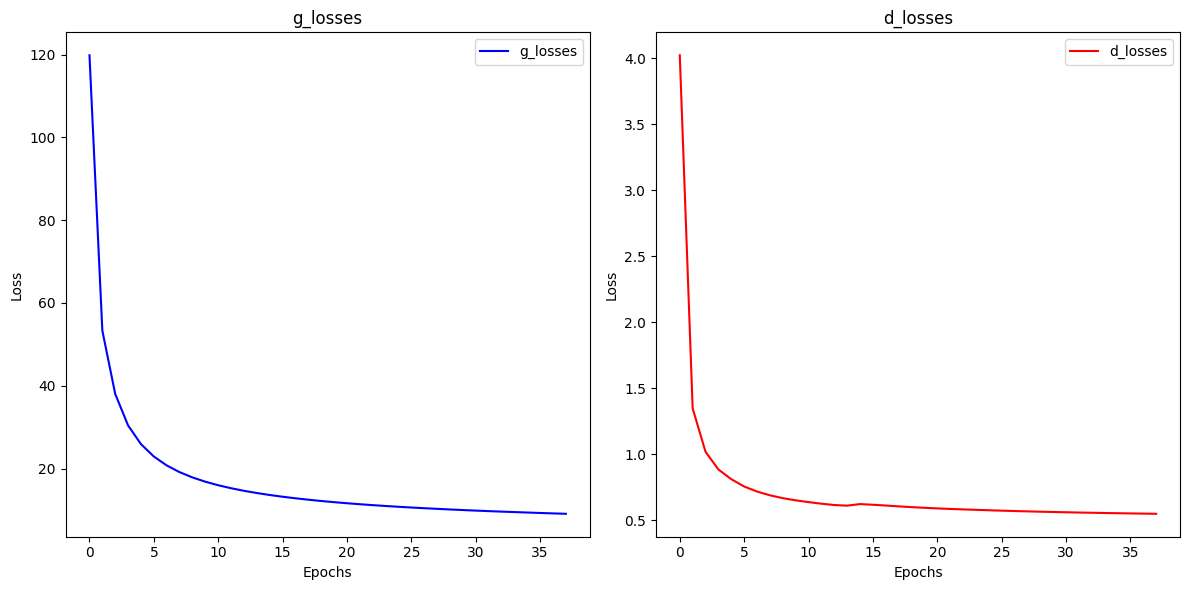

In [ ]:
import re

log_text = """  0%|          | 0/104 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3794']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)
100%|██████████| 104/104 [03:22<00:00,  1.95s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 1, g_loss: 119.8187, d_loss: 4.0244, PSNR: 11.1414, SSIM: 0.3271
100%|██████████| 104/104 [02:02<00:00,  1.17s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 2, g_loss: 53.2930, d_loss: 1.3487, PSNR: 20.3815, SSIM: 0.6180
100%|██████████| 104/104 [02:01<00:00,  1.17s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 3, g_loss: 38.0109, d_loss: 1.0203, PSNR: 23.2328, SSIM: 0.7108
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 4, g_loss: 30.4012, d_loss: 0.8862, PSNR: 23.9866, SSIM: 0.7278
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 5, g_loss: 25.8962, d_loss: 0.8126, PSNR: 24.4746, SSIM: 0.7369
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 6, g_loss: 22.9002, d_loss: 0.7572, PSNR: 24.8698, SSIM: 0.7435
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 7, g_loss: 20.7480, d_loss: 0.7192, PSNR: 25.0147, SSIM: 0.7473
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 8, g_loss: 19.1254, d_loss: 0.6906, PSNR: 25.2647, SSIM: 0.7522
100%|██████████| 104/104 [02:01<00:00,  1.17s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 9, g_loss: 17.8485, d_loss: 0.6691, PSNR: 25.4373, SSIM: 0.7549
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 10, g_loss: 16.8170, d_loss: 0.6526, PSNR: 25.3954, SSIM: 0.7571
100%|██████████| 104/104 [01:59<00:00,  1.15s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 11, g_loss: 15.9633, d_loss: 0.6390, PSNR: 25.5443, SSIM: 0.7597
100%|██████████| 104/104 [01:59<00:00,  1.15s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 12, g_loss: 15.2408, d_loss: 0.6270, PSNR: 25.5821, SSIM: 0.7629
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 13, g_loss: 14.6216, d_loss: 0.6169, PSNR: 25.6423, SSIM: 0.7649
100%|██████████| 104/104 [02:00<00:00,  1.15s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 14, g_loss: 14.0819, d_loss: 0.6122, PSNR: 25.6757, SSIM: 0.7663
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 15, g_loss: 13.6088, d_loss: 0.6241, PSNR: 25.7843, SSIM: 0.7672
100%|██████████| 104/104 [02:01<00:00,  1.17s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 16, g_loss: 13.1893, d_loss: 0.6189, PSNR: 25.7872, SSIM: 0.7679
100%|██████████| 104/104 [02:01<00:00,  1.17s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 17, g_loss: 12.8118, d_loss: 0.6131, PSNR: 25.9041, SSIM: 0.7689
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 18, g_loss: 12.4700, d_loss: 0.6067, PSNR: 25.9145, SSIM: 0.7692
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 19, g_loss: 12.1594, d_loss: 0.6009, PSNR: 25.9413, SSIM: 0.7693
100%|██████████| 104/104 [02:01<00:00,  1.17s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 20, g_loss: 11.8763, d_loss: 0.5959, PSNR: 25.9522, SSIM: 0.7693
100%|██████████| 104/104 [02:01<00:00,  1.17s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 21, g_loss: 11.6169, d_loss: 0.5914, PSNR: 25.8846, SSIM: 0.7696
100%|██████████| 104/104 [02:01<00:00,  1.17s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 22, g_loss: 11.3779, d_loss: 0.5872, PSNR: 25.9256, SSIM: 0.7697
100%|██████████| 104/104 [02:01<00:00,  1.17s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 23, g_loss: 11.1568, d_loss: 0.5839, PSNR: 25.8424, SSIM: 0.7700
100%|██████████| 104/104 [02:01<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 24, g_loss: 10.9519, d_loss: 0.5806, PSNR: 25.8257, SSIM: 0.7707
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 25, g_loss: 10.7615, d_loss: 0.5773, PSNR: 25.8506, SSIM: 0.7710
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 26, g_loss: 10.5831, d_loss: 0.5743, PSNR: 25.8549, SSIM: 0.7716
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 27, g_loss: 10.4177, d_loss: 0.5715, PSNR: 25.7664, SSIM: 0.7711
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 28, g_loss: 10.2628, d_loss: 0.5689, PSNR: 25.8958, SSIM: 0.7715
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 29, g_loss: 10.1145, d_loss: 0.5664, PSNR: 25.9952, SSIM: 0.7723
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 30, g_loss: 9.9728, d_loss: 0.5642, PSNR: 25.9790, SSIM: 0.7725
100%|██████████| 104/104 [02:01<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 31, g_loss: 9.8392, d_loss: 0.5621, PSNR: 25.9642, SSIM: 0.7727
100%|██████████| 104/104 [01:59<00:00,  1.15s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 32, g_loss: 9.7136, d_loss: 0.5601, PSNR: 25.9398, SSIM: 0.7721
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 33, g_loss: 9.5955, d_loss: 0.5583, PSNR: 25.9309, SSIM: 0.7726
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 34, g_loss: 9.4824, d_loss: 0.5565, PSNR: 25.9261, SSIM: 0.7730
100%|██████████| 104/104 [02:00<00:00,  1.16s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 35, g_loss: 9.3735, d_loss: 0.5549, PSNR: 25.8941, SSIM: 0.7727
100%|██████████| 104/104 [02:01<00:00,  1.17s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 36, g_loss: 9.2673, d_loss: 0.5533, PSNR: 25.8832, SSIM: 0.7729
100%|██████████| 104/104 [02:01<00:00,  1.17s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 37, g_loss: 9.1644, d_loss: 0.5519, PSNR: 25.8396, SSIM: 0.7723
100%|██████████| 104/104 [02:01<00:00,  1.17s/it]
WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
Epoch: 38, g_loss: 9.0671, d_loss: 0.5505, PSNR: 25.8880, SSIM: 0.7723
100%|██████████| 104/104 [02:01<00:00,  1.17s/it]"""

# Extract all epochs with g_loss and d_loss
matches = re.findall(r"Epoch:\s*\d+,\s*g_loss:\s*([\d.]+),\s*d_loss:\s*([\d.]+)", log_text)

# Convert to float if needed
g_losses = [float(g) for g, _ in matches]
d_losses = [float(d) for _, d in matches]

print(g_losses)
print(d_losses)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(g_losses, color='b', label='g_losses')
plt.title('g_losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting d_losses
plt.subplot(1, 2, 2)
plt.plot(d_losses, color='r', label='d_losses')
plt.title('d_losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
